In [1]:
%load_ext autoreload
%autoreload 2

# Can U-Net predict only the evidence?

What exactly _is_ the evidence in the Skyline12 dataset anyways?

It's actually _scribbles_ that _roughly_ indicate the position of building on the image. There is an individual scribble (points that form a path of a brush stroke) for each building. In our case, to make them usable we create white brush stroke (of a set stroke size) on a black canvas of the same dimensions as each corresponding image. So the evidence is actually an image with black and white pixels.

In [2]:
from datasets.skyline12 import Skyline12

skyline12 = Skyline12('datasets/skyline12/data/')

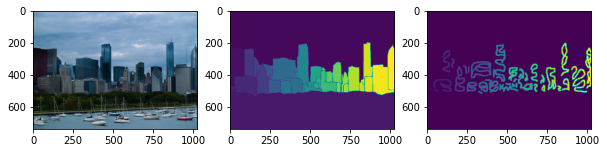

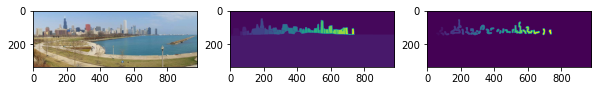

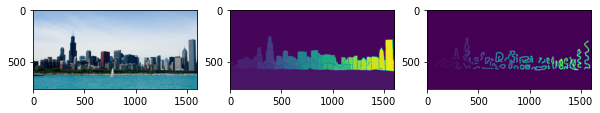

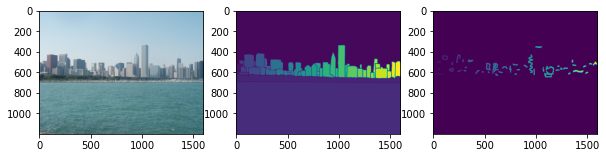

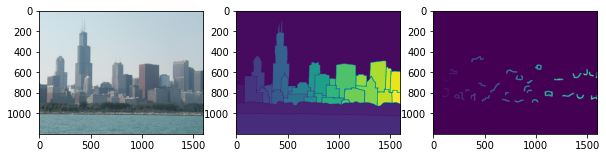

In [3]:
from itertools import islice

for x, y, z in islice(skyline12, 5):
    Skyline12.show_sample(x, [y, z])

As we can see from the small preview of the dataset (ignoring the different colormapping), the scribbles are really sparse. This is expected, as the buildings, at least in the original untampered dataset, take up only a portion of the image. Even so, the density of the drawings vary significantly.

In [4]:
# measuring the class balance
import numpy as np


def get_class_ratio(img):
    img = np.ravel(img)
    pos = img[img > 0]
    neg = img[img == 0]
    return 100 * len(pos) / (len(pos) + len(neg))


class_ratios = np.array([get_class_ratio(z) for _, _, z in skyline12])

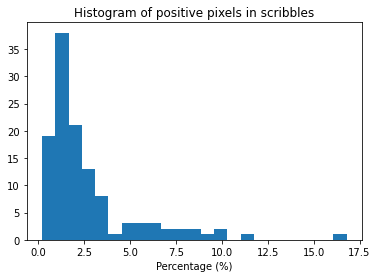

In [5]:
import matplotlib.pyplot as plt

plt.hist(class_ratios, 'auto')
plt.title('Histogram of positive pixels in scribbles')
plt.xlabel('Percentage (%)');

We see that in most of the images in the original Skyline12 dataset, scribbles are less than 2% of the total pixels. That makes it a problem of _class imbalance_ that we need to deal with if we want the model to train fast enough and not spend a number of epochs just to learn to ignore the 0-value pixels. Even worse, it _could_ get trapped in a local minimum, depeding of the loss function and activation that we choose.

## Training with default settings

In [6]:
from models.unet import create_unet

ds = skyline12.as_tf_dataset(folds=1).map(lambda x, y, z: (x, z))

unet = create_unet(num_classes=1, output_activation='sigmoid')
unet.compile(loss='binary_crossentropy', optimizer='adam')
history = unet.fit(ds.batch(4).cache(), epochs=20)

Epoch 1/20
      2/Unknown - 0s 148ms/step - loss: 21.6531WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0967s vs `on_train_batch_end` time: 0.1968s). Check your callbacks.
30/30 [==============================] - 64s 2s/step - loss: 1.6409
Epoch 2/20
30/30 [==============================] - 9s 289ms/step - loss: 0.2056
Epoch 3/20
30/30 [==============================] - 9s 290ms/step - loss: 0.2003
Epoch 4/20
30/30 [==============================] - 9s 290ms/step - loss: 0.1951
Epoch 5/20
30/30 [==============================] - 9s 291ms/step - loss: 0.1934
Epoch 6/20
30/30 [==============================] - 9s 292ms/step - loss: 0.1920
Epoch 7/20
30/30 [==============================] - 9s 292ms/step - loss: 0.1909
Epoch 8/20
30/30 [==============================] - 9s 292ms/step - loss: 0.2072
Epoch 9/20
30/30 [==============================] - 9s 292ms/step - loss: 0.1914
Epoch 10/20
30/30 [==============================] 

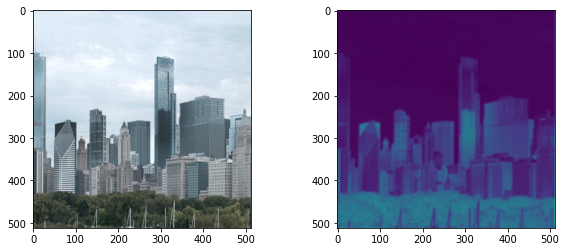

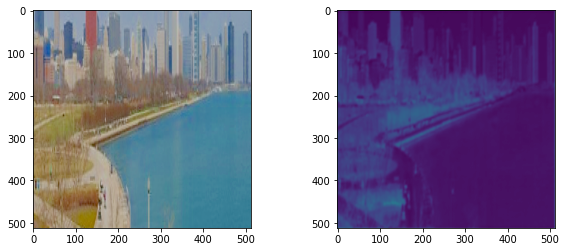

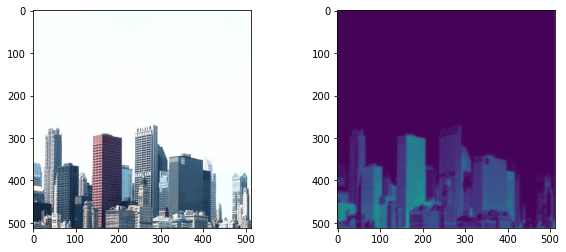

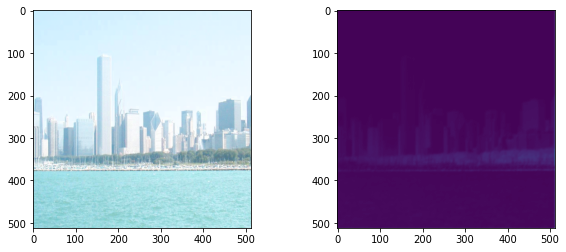

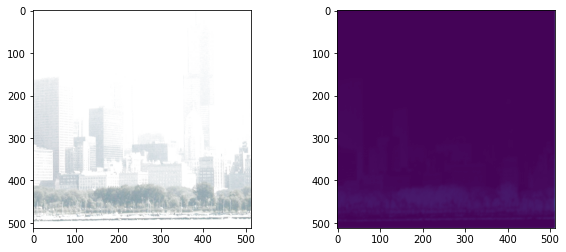

In [7]:
for x, _ in islice(ds.batch(1), 5):
    preds = unet(x, training=False)
    Skyline12.show_sample(x[0], [preds[0]], from_tensors=True)

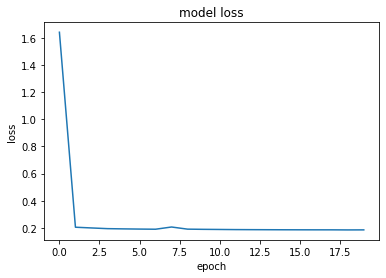

In [8]:
import matplotlib.pyplot as plt


def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    

plot_history(history)

With the model seemignly converging, the predictions are nothing close to the scribbles.

Let's try on a bigger version of the (augmented) dataset

In [9]:
!mkdir -p /tmp/ds_cache/
ds = skyline12.as_tf_dataset(folds=20, cache_dir='/tmp/ds_cache/').map(lambda x, y, z: (x, z))

unet = create_unet(num_classes=1, output_activation='sigmoid')
unet.compile(loss='binary_crossentropy', optimizer='adam')
history = unet.fit(ds.batch(4), epochs=20)

Epoch 1/20
600/600 [==============================] - 1339s 2s/step - loss: 0.2048
Epoch 2/20
600/600 [==============================] - 179s 299ms/step - loss: 0.1836
Epoch 3/20
600/600 [==============================] - 180s 300ms/step - loss: 0.1810
Epoch 4/20
600/600 [==============================] - 180s 300ms/step - loss: 0.1786
Epoch 5/20
600/600 [==============================] - 180s 301ms/step - loss: 0.1759
Epoch 6/20
600/600 [==============================] - 180s 301ms/step - loss: 0.1636
Epoch 7/20
600/600 [==============================] - 180s 300ms/step - loss: 0.1551
Epoch 8/20
600/600 [==============================] - 180s 300ms/step - loss: 0.1508
Epoch 9/20
600/600 [==============================] - 180s 300ms/step - loss: 0.1464
Epoch 10/20
600/600 [==============================] - 180s 300ms/step - loss: 0.1439
Epoch 11/20
600/600 [==============================] - 180s 300ms/step - loss: 0.1424
Epoch 12/20
600/600 [==============================] - 180s 300ms

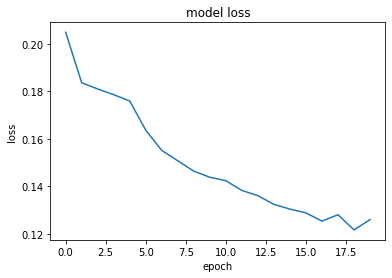

In [11]:
plot_history(history)

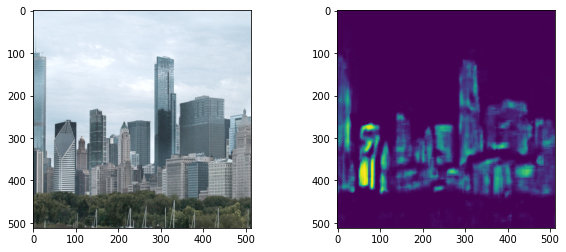

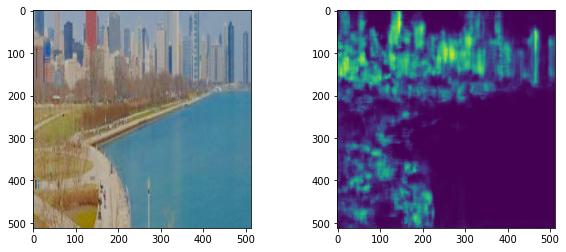

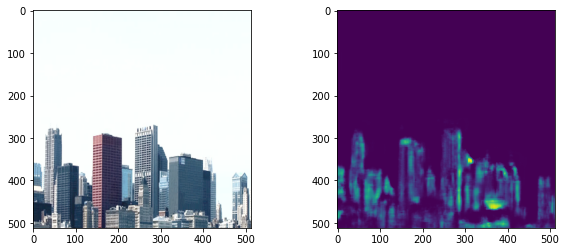

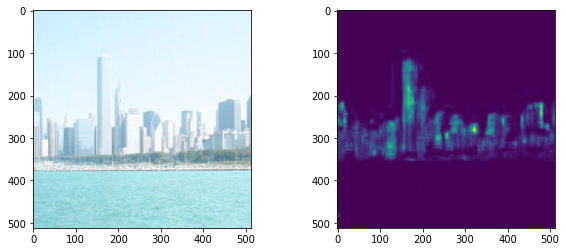

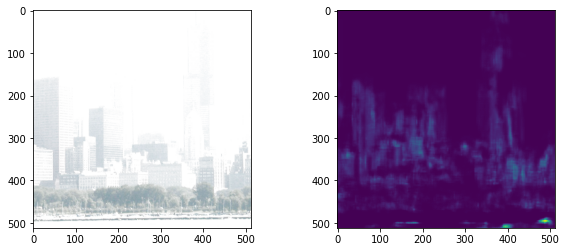

In [10]:
for x, _ in islice(ds.batch(1), 5):
    preds = unet(x, training=False)
    Skyline12.show_sample(x[0], [preds[0]], from_tensors=True)